# HMM

In [22]:
import numpy as np
import literate
import matplotlib.pyplot as plt
import HMM2 as HMM

In [2]:
syldict = literate.syldict("data/Syllable_dictionary.txt")
data, words = literate.read("data/shakespeare.txt", syldict)

print(len(data), "sonnets\n",
      len(words), "unique words\n",
      len(syldict), "words in dictionary")

154 sonnets
 3205 unique words
 3205 words in dictionary


In [3]:
wmap = {w:i for i,w in enumerate(words)}

In [4]:
def toNum(wmap, words):
    return [wmap[w] for w in words]

def toWord(wmap, nums):
    words = list(wmap.keys())
    return [words[i] for i in nums]

def squash(sonnet):
    return [w for l in sonnet for w in l]

In [5]:
squashed = squash(data[0])
transformed = toWord(wmap, toNum(wmap, squashed))

In [13]:
hmm = HMM.unsupervised([toNum(wmap, squash(s)) for s in data], 100, 50)

Training 50 iters
4  9  14  19  24  29  34  39  44  49  
elapsed 1367.184623003006


In [21]:
import pickle
with open("100s-50i.pck", "wb") as f:
    pickle.dump(hmm, f)

In [14]:
em, st = HMM.generate_emission(hmm, 140)
" ".join(toWord(wmap, em))

"breast heart tell days me best good eyes and striving dressings hence what thy old wretch's times lose external own pain fulness be what i have thy measure by thus life others but but in my defendant if elder art stout near eyes for honour maiden in that remedy decease lie thy face o chase should that that the kind of unfathered that 'gainst beside time shall new derive bears debt and for my foregone self 'greeing and upon seldom name is then no thou than partly strong i when that then not you or didst thou then not nor thee i am thy will on tells the feathered progress perfection saw madding stand then youth drink make as in absence of the world's or my wit loving for i may ever which i perceive she unseen her when th'"

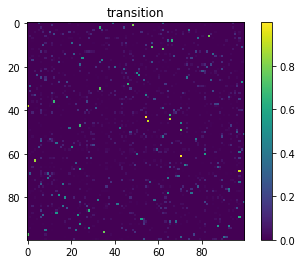

In [32]:
plt.title("transition")
plt.imshow(hmm.A)
plt.colorbar()

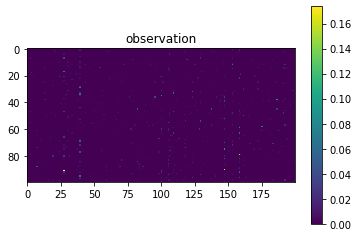

In [29]:
plt.title("observation")
plt.imshow(hmm.O[:,:200])
plt.colorbar()